# Evaluation for the Miscellaneous and ICNP Datasets 

## Importing Datasets

In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras import metrics
from matplotlib import pyplot
# from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import random
from datetime import datetime
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
# %matplotlib notebook
import tensorflow as tf
from tensorflow.python.client import device_lib
import pprint
from scipy import interpolate

2023-06-20 02:24:11.396916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 02:24:12.082397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 02:24:12.085132: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 02:24:15.116720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Adding a raise exception for clean execution exit from a cell
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Dataset Preparation

Please download the dataset from the following link:
https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/hsr_misc_datasets.zip

In a terminal, you can use `wget https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/hsr_misc_datasets.zip`. If you are using Google Colab, you can run the following in a cell:

`wget https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/hsr_misc_datasets.zip`

## Loading up the model and setting up functions

### Load model according to window size

Uncomment the line with the model url, and use `wget` to download the model from the given url.

In [3]:
WINDOW_SIZE = 6

HSR_datasets = ["/HSR_August_Dataset", "/HSR_July_Dataset"]
Misc_datasets = ["/ATT_Dataset", "/Sprint_Dataset", "/Verizon_Dataset"]

HSR_datasets = ["with_RAW_CNXT" + f for f in HSR_datasets]
Misc_datasets = ["with_RAW_CNXT" + f for f in Misc_datasets]

# DOWNLOAD THE MODEL FROM THE URL BELOW, UNCOMMENT LINES IF YOU ARE USING GOOGLE COLAB

# model_url = "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/models/model_WS" + str(WINDOW_SIZE) + ".h5"
# print(model_url)

# !wget {model_url} -O "model.h5"

model_eval = load_model("model.h5")
window_size = WINDOW_SIZE

2023-06-20 02:24:23.260860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 02:24:23.265212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 02:24:23.269104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [4]:
# HELPER FUNCTION DECLARATIONS

# Helper function to convert string to timestamp
def string_to_datetime_incp(timestamp):
  return float(timestamp)


# Helper function to convert strings into datetime objects
def string_to_datetime(timestamp_str):
    try:
        time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X.%f")
    except:
        time_b = datetime.strptime(timestamp_str, "%Y-%m-%d %X")
    return time_b


# This function extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
def add_to_df_wts(filepath, window_size):
  df = pd.read_csv(filepath)
  df.drop(["Unnamed: 0"], axis=1, inplace=True)

  entries = []

  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)

  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object

      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      tth_seconds = tth.total_seconds()

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

    return entries

  return


# This function extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
def add_to_df_wts_incp(filepath, window_size):
  df = pd.read_csv(filepath)
  # df.drop(["Unnamed: 0"], axis=1, inplace=True)

  entries = []

  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime_incp(last_entry_ts)

  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime_incp(last_window_ts) # last window timestamp datetime object

      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      # tth_seconds = tth.total_seconds()
      tth_seconds = tth

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

    return entries

  return

# Function to detect if there are no "target" entries in here
def check_valid(sequence_dict, key):
  ho_event_list = sequence_dict[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      # print(sequence_dict[key][i][0][2])
      if label == 1:
        return True
  return False

# Helper function to check if the current handover event is valid to be used for evaluation
def check_valid_2(sd, key):
  ho_event_list = sd[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sd[key][i][0][2]
      if label == 1:
        return True
  return False


In [5]:
# Helper function for loading up dataset:
def load_dataset(datasets_list, WINDOW_SIZE):
  # HSR_datasets is a placeholder variable.
  sequence_dict = {}

  ho_event_no = 0 # This counter keeps track of which handover event we have reached
  for master_f in datasets_list:
    dataset_folders = os.listdir(master_f)
    for folder in dataset_folders:
      folder_path = master_f + "/" + folder
      files = os.listdir(folder_path)
      ho_event_no += 1
      curr_hoevent_entries = [] # list containing all the data for the current handover event
      for f in files:
        filepath = folder_path + "/" + f
        entries = add_to_df_wts(filepath, window_size)
        curr_hoevent_entries.append(entries)
      sequence_dict[ho_event_no] = curr_hoevent_entries

  sequence_dict_orig = sequence_dict.copy()

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          if subentry[2] == "not_target":
            sequence_dict[key][i1][i2][2] = 0
          else:
            sequence_dict[key][i1][i2][2] = 1

  sequence_dict_renamed = sequence_dict.copy()

  sequence_dict = sequence_dict_orig.copy()

  # Using minmax scaling to bring our features between 0 and 1
  scaler = MinMaxScaler(feature_range=(0,1))

  rsrp_list = []
  rsrq_list = []
  rsrp_raws_list = []
  rsrq_raws_list = []
  labels = []

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    if check_valid(sequence_dict, key):
      for i1, entry in enumerate(ho_event_list):
        if entry is not None:
          for i2, subentry in enumerate(entry):
            req_idx = len(rsrp_list)
            rsrp = np.array(sequence_dict[key][i1][i2][0])
            rsrq = np.array(sequence_dict[key][i1][i2][1])
            label = np.array(sequence_dict[key][i1][i2][2])
            rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
            rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
            rsrp_list.append(rsrp)
            rsrq_list.append(rsrq)
            rsrp_raws_list.append(rsrp_raws)
            rsrq_raws_list.append(rsrq_raws)
            labels.append(label)
            sequence_dict[key][i1][i2][0] = req_idx
            sequence_dict[key][i1][i2][1] = req_idx
            sequence_dict[key][i1][i2][4] = req_idx
            sequence_dict[key][i1][i2][5] = req_idx
            # sequence_dict[key][i1][i2][2] = req_idx

  rsrp_tts = scaler.fit_transform(rsrp_list)
  rsrq_tts = scaler.fit_transform(rsrq_list)
  rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
  rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

  # Combining features
  HSR_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

  # Reshaping label data
  HSR_labels = np.reshape(labels, (len(labels),1))

  return HSR_features, HSR_labels, sequence_dict, sequence_dict_orig

# Helper function specifically for loading the INCP dataset, which has a slightly different format (both in terms of data types and column titles)
def load_incp_dataset(WINDOW_SIZE):
  # Iterate over the files and populate sequence_dict
  dataset_master_folders = ["icnp-dataset/ATT", "icnp-dataset/TMobile"]

  sequence_dict = {}

  ho_event_no = 0 # This counter keeps track of which handover event we have reached
  for master_f in dataset_master_folders:
    dataset_folders = os.listdir(master_f)
    for folder in dataset_folders:
      folder_path = master_f + "/" + folder
      files = os.listdir(folder_path)
      ho_event_no += 1
      curr_hoevent_entries = [] # list containing all the data for the current handover event
      for f in files:
        filepath = folder_path + "/" + f
        entries = add_to_df_wts_incp(filepath, WINDOW_SIZE)
        curr_hoevent_entries.append(entries)
      sequence_dict[ho_event_no] = curr_hoevent_entries

  sequence_dict_orig = sequence_dict.copy()

  # Renaming the labels and converting into required data types

  # sequence_dict = sequence_dict_orig.copy()

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          if subentry[2] == "not_target":
            sequence_dict[key][i1][i2][2] = 0
          else:
            sequence_dict[key][i1][i2][2] = 1

  sequence_dict_renamed = sequence_dict.copy()

  sequence_dict = sequence_dict_orig.copy()

  # Using minmax scaling to bring our features between 0 and 1
  scaler = MinMaxScaler(feature_range=(0,1))

  rsrp_list = []
  rsrq_list = []
  rsrp_raws_list = []
  rsrq_raws_list = []
  labels = []

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    if check_valid(sequence_dict, key):
      for i1, entry in enumerate(ho_event_list):
        if entry is not None:
          for i2, subentry in enumerate(entry):
            req_idx = len(rsrp_list)
            rsrp = np.array(sequence_dict[key][i1][i2][0])
            rsrq = np.array(sequence_dict[key][i1][i2][1])
            label = np.array(sequence_dict[key][i1][i2][2])
            rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
            rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
            rsrp_list.append(rsrp)
            rsrq_list.append(rsrq)
            rsrp_raws_list.append(rsrp_raws)
            rsrq_raws_list.append(rsrq_raws)
            labels.append(label)
            sequence_dict[key][i1][i2][0] = req_idx
            sequence_dict[key][i1][i2][1] = req_idx
            sequence_dict[key][i1][i2][4] = req_idx
            sequence_dict[key][i1][i2][5] = req_idx
            # sequence_dict[key][i1][i2][2] = req_idx

  rsrp_tts = scaler.fit_transform(rsrp_list)
  rsrq_tts = scaler.fit_transform(rsrq_list)
  rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
  rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

  # Combining features
  features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

  # Reshaping label data
  labels = np.reshape(labels, (len(labels),1))

  return features, labels, sequence_dict, sequence_dict_orig


## Padding in feature vector generation

### Padding Helper Function definitions

In [6]:
# helper function that checks whether or not the current df will require padding
def padding_condition_check(df, window_size, handover_ts):
  # fails basic length check
  if len(df) < window_size:
    return True
  # calculating time diff
  window1 = df[0:window_size]
  last_entry = df.iloc[window_size-1]
  last_entry_ts = last_entry["timestamp"]
  le_ts_datetime = string_to_datetime(last_entry_ts)
  ho_diff = handover_ts - le_ts_datetime
  ho_diff_seconds = ho_diff.total_seconds()
  # fails time check
  if ho_diff_seconds <= 0.1:
    return True
  return False

# helper function to extract entries from a dataframe and append them to the "entries" list
def extract_entries(df, window_size, ho_ts_datetime):
  entries = []
  for i in range(df.shape[0] - window_size + 1):
    df_slice = df.iloc[i:i+window_size]
    # Extracting the last timestamp for this window
    last_window_entry = df.iloc[i+window_size-1]
    last_window_ts = last_window_entry["timestamp"]
    lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object

    # Calculating time to handover and adding it to ttp
    tth = ho_ts_datetime - lw_ts_dt # time to handover
    tth_seconds = tth.total_seconds()

    rsrp = df_slice["rsrp"]
    rsrq = df_slice["rsrq"]
    rsrp_raw = df_slice["rsrp_raw"]
    rsrq_raw = df_slice["rsrq_raw"]
    label = df.iloc[i]
    label = label["label"]

    entry = []
    entry.append(rsrp)
    entry.append(rsrq)
    entry.append(label)
    entry.append(tth_seconds)
    entry.append(rsrp_raw)
    entry.append(rsrq_raw)

    entries.append(entry)

  return entries

# helper function that returns the entries list as it would have appeared in regular execution
def regular_extension(df, window_size):
  entries = []
  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)
  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object

      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      tth_seconds = tth.total_seconds()

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

  return entries

# dataframe containing features is passed as argument to this function along with the window size
# helper function that returns a list of entries for the input dataframe by performing backward padding: i.e., appending the last value to the end as many times as needed
def backward_padding(df, window_size):
  entries = []
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)

  # simple padding in case the window is simply not long enough
  if len(df) < window_size:
    for i in range(len(df)):
      # index to check => len(df)-1-i
      df_temp = df[0:i+1]
      num_reps = window_size - 1 - i # number of times the entry needs to be repeated
      to_repeat = df.iloc[i]
      for i in range(num_reps):
        df_temp = pd.concat([df_temp, to_repeat.to_frame().T], ignore_index = True)
      entries_curr_iter = extract_entries(df_temp, window_size, ho_ts_datetime) # entries from the current iteration
      entries.extend(entries_curr_iter)

  # timer check
  else:
    for i in range(df.shape[0]-1):
      # this check ensure that we have all the measurements we can get till this point
      # hence, this iterable should not go past window_size
      if i == window_size:
        break

      df_temp = df[0:i+1]
      num_reps = window_size - 1 - i # number of times the entry needs to be repeated
      to_repeat = df.iloc[i]
      for i in range(num_reps):
        df_temp = pd.concat([df_temp, to_repeat.to_frame().T], ignore_index = True)
      entries_curr_iter = extract_entries(df_temp, window_size, ho_ts_datetime)
      entries.extend(entries_curr_iter)

    # also need regular extension
    reg_extension_entries = regular_extension(df, window_size)
    entries.extend(reg_extension_entries)

  return entries

# extracts "entries" from a file, which is a list of lists containing feature vectors
def add_to_entries(filepath, window_size):
  df = pd.read_csv(filepath)
  df.drop(["Unnamed: 0"], axis=1, inplace=True)

  ho_entry = df.iloc[-1]
  ho_entry_ts = ho_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(ho_entry_ts)

  entries = []

  if padding_condition_check(df, window_size, ho_ts_datetime):
    # make longer vectors using padding
    # COMMENT THIS LINE OUT TO USE WHICHEVER PADDING METHOD YOU WANT TO TEST
    # entries = backward_padding(df, window_size)
    entries = le_padding(df, window_size)
    return entries
  else:
    # normal execution (without padding)
    entries = regular_extension(df, window_size)
    return entries

### Linear Extrapolation padding implementation

In [15]:
from scipy import interpolate
input_arr = np.array([1.5,2.5])
len_input_arr = len(input_arr)
x_arr = np.arange(0, len(input_arr))
f = interpolate.interp1d(x_arr, input_arr, fill_value='extrapolate')
for i in range(len_input_arr, 6):
    input_arr = np.append(input_arr, f(i))
print(input_arr)

[1.5 2.5 3.5 4.5 5.5 6.5]


In [7]:
# helper function to perform linear extrapolation on a list
def le_meas_list(input, window_size):
    input_arr = np.array(input)
    input_arr_len = len(input_arr) # we save this here to use later as an iterator
    if input_arr_len == 1:
        input_arr = np.repeat(input_arr[0], window_size)
    else:
        x_arr = np.arange(0, input_arr_len)
        f = interpolate.interp1d(x_arr, input_arr, fill_value='extrapolate')
        for i in range(input_arr_len, window_size):
            input_arr = np.append(input_arr, f(i))
    return input_arr

# helper function that performs linear extrapolation padding to a dataframe of entries
def le_df_padder(df, window_size):
    final_df = pd.DataFrame()
    timestamps = list(df["timestamp"])
    for i in range(window_size - len(df)):
        timestamps.append(timestamps[-1])
    final_df["timestamp"] = timestamps
    final_df["rsrp"] = le_meas_list(list(df["rsrp"]), window_size)
    final_df["rsrq"] = le_meas_list(list(df["rsrq"]), window_size)
    final_df["rsrp_raw"] = le_meas_list(list(df["rsrp_raw"]), window_size)
    final_df["rsrq_raw"] = le_meas_list(list(df["rsrq_raw"]), window_size)
    final_df["label"] = [df.iloc[0]["label"] for i in range(window_size)]

    return final_df

## helper function that performs linear extrapolation padding, i.e. extrapolating the values based on a linear gradient so far
def le_padding(df, window_size):
    entries = []
    last_entry = df.iloc[-1]
    last_entry_ts = last_entry["timestamp"]
    ho_ts_datetime = string_to_datetime(last_entry_ts)

    # if not long enough
    if len(df) < window_size:
        for i in range(len(df)):
            temp_df = df.iloc[0:i+1]
            temp_df = le_df_padder(temp_df, window_size)
            entries_curr_iter = extract_entries(temp_df, window_size, ho_ts_datetime)
            entries.extend(entries_curr_iter)

    # if problem is time
    else:
        for i in range(df.shape[0]-1):
            # this check ensure that we have all the measurements we can get till this point
            # hence, this iterable should not go past window_size
            if i == window_size:
                break
            temp_df = df[0:i+1]
            temp_df = le_df_padder(temp_df, window_size)
            entries_curr_iter = extract_entries(temp_df, window_size, ho_ts_datetime)
            entries.extend(entries_curr_iter)
            
        # also need regular extension
        reg_extension_entries = regular_extension(df, window_size)
        entries.extend(reg_extension_entries)

    return entries

### Padding Main Loader

In [8]:
# rsrp_list = []
# rsrq_list = []
# rsrp_raws_list = []
# rsrq_raws_list = []
# labels = []

# Helper function for loading up dataset:
def load_dataset_padding(datasets_list, WINDOW_SIZE):
  # HSR_datasets is a placeholder variable.
  sequence_dict = {}

  diff_count = 0

  ho_event_no = 0 # This counter keeps track of which handover event we have reached
  for master_f in datasets_list:
    dataset_folders = os.listdir(master_f)
    for folder in dataset_folders:
      folder_path = master_f + "/" + folder
      files = os.listdir(folder_path)
      ho_event_no += 1
      curr_hoevent_entries = [] # list containing all the data for the current handover event
      for f in files:
        filepath = folder_path + "/" + f
        len_entries = 0
        len_entries2 = 0
        entries = add_to_entries(filepath, WINDOW_SIZE)
        curr_hoevent_entries.append(entries)
      sequence_dict[ho_event_no] = curr_hoevent_entries

  sequence_dict_orig = sequence_dict.copy()

  print("DIFF COUNT CHECK:", diff_count)

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          if subentry[2] == "not_target":
            sequence_dict[key][i1][i2][2] = 0
          else:
            sequence_dict[key][i1][i2][2] = 1

  sequence_dict_renamed = sequence_dict.copy()

  sequence_dict = sequence_dict_orig.copy()

  # Using minmax scaling to bring our features between 0 and 1
  scaler = MinMaxScaler(feature_range=(0,1))

  rsrp_list = []
  rsrq_list = []
  rsrp_raws_list = []
  rsrq_raws_list = []
  labels = []

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    if check_valid(sequence_dict, key):
      for i1, entry in enumerate(ho_event_list):
        if entry is not None:
          for i2, subentry in enumerate(entry):
            req_idx = len(rsrp_list)
            rsrp = np.array(sequence_dict[key][i1][i2][0])
            rsrq = np.array(sequence_dict[key][i1][i2][1])
            label = np.array(sequence_dict[key][i1][i2][2])
            rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
            rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
            rsrp_list.append(rsrp)
            rsrq_list.append(rsrq)
            rsrp_raws_list.append(rsrp_raws)
            rsrq_raws_list.append(rsrq_raws)
            labels.append(label)
            sequence_dict[key][i1][i2][0] = req_idx
            sequence_dict[key][i1][i2][1] = req_idx
            sequence_dict[key][i1][i2][4] = req_idx
            sequence_dict[key][i1][i2][5] = req_idx
            # sequence_dict[key][i1][i2][2] = req_idx

  # print(rsrp_list)

  rsrp_tts = scaler.fit_transform(rsrp_list)
  rsrq_tts = scaler.fit_transform(rsrq_list)
  rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
  rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

  # Combining features
  HSR_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

  # Reshaping label data
  HSR_labels = np.reshape(labels, (len(labels),1))

  return HSR_features, HSR_labels, sequence_dict, sequence_dict_orig

### Padding Helper Functions INCP definitions

In [9]:
## HELPER FUNCTION DEFINITIONS FOR PADDING IN THE INCP DATASET

# helper function to implement linear extrapolation padding
def le_padding_incp(df, window_size):
  entries = []
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime_incp(last_entry_ts)

  # simple padding in case the window is simply not long enough
  if len(df) < window_size:
    padded_df = None
    for i in range(len(df)):
      # index to check => len(df)-1-i
      df_temp = df[0:i+1]
      df_temp = le_df_padder(df_temp, window_size)
      entries_curr_iter = extract_entries_incp(df_temp, window_size, ho_ts_datetime) # entries from the current iteration
      entries.extend(entries_curr_iter)

  # timer check
  else:
    for i in range(df.shape[0]-1):
      # this check ensure that we have all the measurements we can get till this point
      # hence, this iterable should not go past window_size
      if i == window_size:
        break

      df_temp = df[0:i+1]
      df_temp = le_df_padder(df_temp, window_size)
      entries_curr_iter = extract_entries_incp(df_temp, window_size, ho_ts_datetime)
      entries.extend(entries_curr_iter)

    # also need regular extension
    reg_extension_entries = regular_extension_incp(df, window_size)
    entries.extend(reg_extension_entries)

  return entries

# helper function that checks whether or not the current df will require padding
def padding_condition_check_incp(df, window_size, handover_ts):
  # fails basic length check
  if len(df) < window_size:
    return True
  # calculating time diff
  window1 = df[0:window_size]
  last_entry = df.iloc[window_size-1]
  last_entry_ts = last_entry["timestamp"]
  le_ts_datetime = string_to_datetime_incp(last_entry_ts)
  ho_diff_seconds = handover_ts - le_ts_datetime
  # fails time check
  if ho_diff_seconds <= 0.1:
    return True
  return False

# helper function to extract entries from a dataframe and append them to the "entries" list
def extract_entries_incp(df, window_size, ho_ts_datetime):
  entries = []
  for i in range(df.shape[0] - window_size + 1):
    df_slice = df.iloc[i:i+window_size]
    # Extracting the last timestamp for this window
    last_window_entry = df.iloc[i+window_size-1]
    last_window_ts = last_window_entry["timestamp"]
    lw_ts_dt = string_to_datetime_incp(last_window_ts) # last window timestamp datetime object

    # Calculating time to handover and adding it to ttp
    tth_seconds = ho_ts_datetime - lw_ts_dt # time to handover

    rsrp = df_slice["rsrp"]
    rsrq = df_slice["rsrq"]
    rsrp_raw = df_slice["rsrp_raw"]
    rsrq_raw = df_slice["rsrq_raw"]
    label = df.iloc[i]
    label = label["label"]

    entry = []
    entry.append(rsrp)
    entry.append(rsrq)
    entry.append(label)
    entry.append(tth_seconds)
    entry.append(rsrp_raw)
    entry.append(rsrq_raw)

    entries.append(entry)

  return entries

# helper function that returns the entries list as it would have appeared in regular execution
def regular_extension_incp(df, window_size):
  entries = []
  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime_incp(last_entry_ts)
  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime_incp(last_window_ts) # last window timestamp datetime object

      # Calculating time to handover and adding it to ttp
      tth_seconds = ho_ts_datetime - lw_ts_dt # time to handover

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

  return entries

# dataframe containing features is passed as argument to this function along with the window size
# helper function that returns a list of entries for the input dataframe
def backward_padding_incp(df, window_size):
  entries = []
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime_incp(last_entry_ts)

  # simple padding in case the window is simply not long enough
  if len(df) < window_size:
    padded_df = None
    for i in range(len(df)):
      # index to check => len(df)-1-i
      df_temp = df[0:i+1]
      num_reps = window_size - 1 - i # number of times the entry needs to be repeated
      to_repeat = df.iloc[i]
      for i in range(num_reps):
        df_temp = pd.concat([df_temp, to_repeat.to_frame().T], ignore_index = True)
      entries_curr_iter = extract_entries_incp(df_temp, window_size, ho_ts_datetime) # entries from the current iteration
      entries.extend(entries_curr_iter)

  # timer check
  else:
    for i in range(df.shape[0]-1):
      # this check ensure that we have all the measurements we can get till this point
      # hence, this iterable should not go past window_size
      if i == window_size:
        break

      df_temp = df[0:i+1]
      num_reps = window_size - 1 - i # number of times the entry needs to be repeated
      to_repeat = df.iloc[i]
      for i in range(num_reps):
        df_temp = pd.concat([df_temp, to_repeat.to_frame().T], ignore_index = True)
      entries_curr_iter = extract_entries_incp(df_temp, window_size, ho_ts_datetime)
      entries.extend(entries_curr_iter)

    # also need regular extension
    reg_extension_entries = regular_extension_incp(df, window_size)
    entries.extend(reg_extension_entries)

  return entries

# extracts "entries" from a file, which is a list of lists containing feature vectors
def add_to_entries_incp(filepath, window_size):
  df = pd.read_csv(filepath)

  ho_entry = df.iloc[-1]
  ho_entry_ts = ho_entry["timestamp"]
  ho_ts_datetime = string_to_datetime_incp(ho_entry_ts)

  entries = []

  if padding_condition_check_incp(df, window_size, ho_ts_datetime):
    # make longer vectors using padding
    # entries = backward_padding_incp(df, window_size)
    entries = le_padding_incp(df, window_size)
    return entries
  else:
    # normal execution (without padding)
    entries = regular_extension_incp(df, window_size)
    return entries


# Helper function specifically for loading the INCP dataset, which has a slightly different format (both in terms of data types and column titles)
def load_incp_dataset_padding(WINDOW_SIZE):
  # Iterate over the files and populate sequence_dict
  dataset_master_folders = ["icnp-dataset/ATT", "icnp-dataset/TMobile"]

  sequence_dict = {}

  ho_event_no = 0 # This counter keeps track of which handover event we have reached
  for master_f in dataset_master_folders:
    dataset_folders = os.listdir(master_f)
    for folder in dataset_folders:
      folder_path = master_f + "/" + folder
      files = os.listdir(folder_path)
      ho_event_no += 1
      curr_hoevent_entries = [] # list containing all the data for the current handover event
      for f in files:
        filepath = folder_path + "/" + f
        # entries = add_to_df_wts_incp(filepath, WINDOW_SIZE)
        entries = add_to_entries_incp(filepath, WINDOW_SIZE)
        curr_hoevent_entries.append(entries)
      sequence_dict[ho_event_no] = curr_hoevent_entries

  sequence_dict_orig = sequence_dict.copy()

  # Renaming the labels and converting into required data types

  # sequence_dict = sequence_dict_orig.copy()

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          if subentry[2] == "not_target":
            sequence_dict[key][i1][i2][2] = 0
          else:
            sequence_dict[key][i1][i2][2] = 1

  sequence_dict_renamed = sequence_dict.copy()

  sequence_dict = sequence_dict_orig.copy()

  # Using minmax scaling to bring our features between 0 and 1
  scaler = MinMaxScaler(feature_range=(0,1))

  rsrp_list = []
  rsrq_list = []
  rsrp_raws_list = []
  rsrq_raws_list = []
  labels = []

  for key in sequence_dict.keys():
    ho_event_list = sequence_dict[key]
    if check_valid(sequence_dict, key):
      for i1, entry in enumerate(ho_event_list):
        if entry is not None:
          for i2, subentry in enumerate(entry):
            req_idx = len(rsrp_list)
            rsrp = np.array(sequence_dict[key][i1][i2][0])
            rsrq = np.array(sequence_dict[key][i1][i2][1])
            label = np.array(sequence_dict[key][i1][i2][2])
            rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
            rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
            rsrp_list.append(rsrp)
            rsrq_list.append(rsrq)
            rsrp_raws_list.append(rsrp_raws)
            rsrq_raws_list.append(rsrq_raws)
            labels.append(label)
            sequence_dict[key][i1][i2][0] = req_idx
            sequence_dict[key][i1][i2][1] = req_idx
            sequence_dict[key][i1][i2][4] = req_idx
            sequence_dict[key][i1][i2][5] = req_idx
            # sequence_dict[key][i1][i2][2] = req_idx

  rsrp_tts = scaler.fit_transform(rsrp_list)
  rsrq_tts = scaler.fit_transform(rsrq_list)
  rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
  rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

  # Combining features
  features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

  # Reshaping label data
  labels = np.reshape(labels, (len(labels),1))

  return features, labels, sequence_dict, sequence_dict_orig


# HANDOVER PREDICTION

## Evaluating for HSR dataset

In [ ]:
WINDOW_SIZE = 6

sequence_dict = {}

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in HSR_datasets:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, window_size)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx

rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
HSR_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
HSR_labels = np.reshape(labels, (len(labels),1))

In [ ]:
predictions = model_eval.predict(HSR_features)
HSR_predictions = (predictions > 0.37)
cm = confusion_matrix(HSR_labels, HSR_predictions)
tn, fp, fn, tp = cm.ravel()

earliest_times = []
earliest_HO_times = {}
TOTAL_VALID_EVENTS = 0
FAILED_PREDICTING = 0

# Predicting handover events
for HO_COUNT, key in enumerate(sequence_dict.keys()):
  # variable that checks if the handover for the current event has been predicted
  HO_PREDICTED = False
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    TOTAL_VALID_EVENTS += 1
    for i1, entry in enumerate(ho_event_list): # check for the current HO event
      # if HO_PREDICTED == True:
      #   break
      if entry is not None:
        for i2, subentry in enumerate(entry): # this inner loop checks everything for a single base station
          # if HO_PREDICTED == True:
          #   break
          req_idx = sequence_dict[key][i1][i2][0]
          label = HSR_labels[req_idx][0]
          curr_ts = sequence_dict[key][i1][i2][3]
          prediction = HSR_predictions[req_idx]
          if prediction == 1: # if a handover is predicted
            HO_PREDICTED = True
            # earliest_times.append(curr_ts)
            if key in earliest_HO_times:
              if curr_ts > earliest_HO_times[key]:
                earliest_HO_times[key] = curr_ts
            else:
              earliest_HO_times[key] = curr_ts
    if HO_PREDICTED == False:
      FAILED_PREDICTING += 1

for key in earliest_HO_times.keys():
  earliest_times.append(earliest_HO_times[key])

351/351 [==============================] - 2s 3ms/step


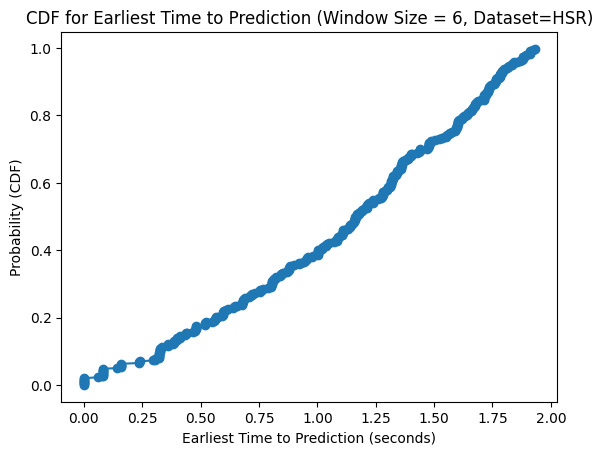

                0
count  399.000000
mean     1.096356
std      0.529935
min      0.000000
25%      0.680144
50%      1.162110
75%      1.566207
max      1.931053
Failed predicting for: 6handover events
90:  94.9874686716792
100:  94.9874686716792
200:  93.48370927318295
500:  82.20551378446115
1000:  61.40350877192983


In [ ]:
%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earliest Time to Prediction (Window Size = 6, Dataset=HSR)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())

print("Failed predicting for: " + str(FAILED_PREDICTING) + "handover events")

g100 = 0
g200 = 0
g500 = 0
g1000 = 0
g90 = 0

for x in earliest_times:
  if x >= 0.09:
    g90 += 1
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("90: ", g90/N * 100)
print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)

with open("HSR_HO_predictions.txt", "w") as output:
    for item in earliest_times:
        output.write(str(item) + "\n")

## Evaluating the Misc dataset

In [ ]:
WINDOW_SIZE = 6

sequence_dict = {}

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in Misc_datasets:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, window_size)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx

rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
Misc_features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
Misc_labels = np.reshape(labels, (len(labels),1))

In [ ]:
predictions = model_eval.predict(Misc_features)
Misc_predictions = (predictions > 0.37)
cm = confusion_matrix(Misc_labels, Misc_predictions)
tn, fp, fn, tp = cm.ravel()

earliest_times = []
earliest_HO_times = {}
TOTAL_VALID_EVENTS = 0
FAILED_PREDICTING = 0

# Predicting handover events
for HO_COUNT, key in enumerate(sequence_dict.keys()):
  # variable that checks if the handover for the current event has been predicted
  HO_PREDICTED = False
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    TOTAL_VALID_EVENTS += 1
    for i1, entry in enumerate(ho_event_list): # check for the current HO event
      # if HO_PREDICTED == True:
      #   break
      if entry is not None:
        for i2, subentry in enumerate(entry): # this inner loop checks everything for a single base station
          # if HO_PREDICTED == True:
          #   break
          req_idx = sequence_dict[key][i1][i2][0]
          label = Misc_labels[req_idx][0]
          curr_ts = sequence_dict[key][i1][i2][3]
          prediction = Misc_predictions[req_idx]
          if prediction == 1: # if a handover is predicted
            HO_PREDICTED = True
            if key in earliest_HO_times:
              if curr_ts > earliest_HO_times[key]:
                earliest_HO_times[key] = curr_ts
            else:
              earliest_HO_times[key] = curr_ts
    if HO_PREDICTED == False:
      FAILED_PREDICTING += 1

for key in earliest_HO_times.keys():
  earliest_times.append(earliest_HO_times[key])

356/356 [==============================] - 1s 2ms/step


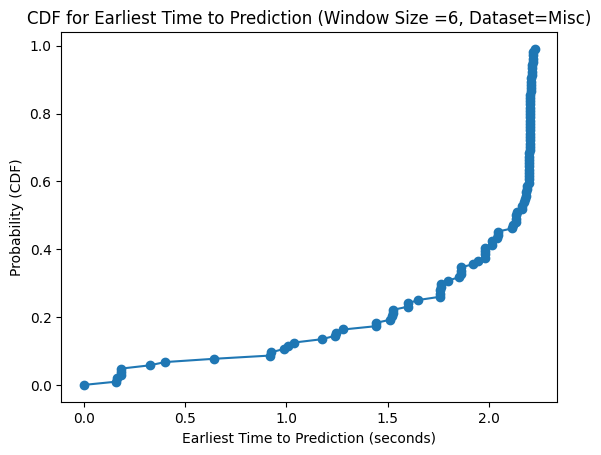

                0
count  104.000000
mean     1.812962
std      0.594371
min      0.000000
25%      1.635262
50%      2.131077
75%      2.200292
max      2.224869
90:  99.03846153846155
100:  99.03846153846155
200:  94.23076923076923
500:  92.3076923076923
1000:  88.46153846153845


In [ ]:
%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earliest Time to Prediction (Window Size =" + str(WINDOW_SIZE) +", Dataset=Misc)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())


g100 = 0
g200 = 0
g500 = 0
g1000 = 0
g90 = 0

for x in earliest_times:
  if x >= 0.09:
    g90 += 1
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("90: ", g90/N * 100)
print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)

with open("Misc_HO_predictions.txt", "w") as output:
    for item in earliest_times:
        output.write(str(item) + "\n")


## Evaluating for the ICNP Dataset

Run the following cell if you are using Google Colab, or run the two lines in a terminal (without the '!').

In [ ]:
!wget "https://anonymous.4open.science/api/repo/EdgeCatBSPDataset-1840/file/driving_dataset.zip"
!unzip "driving_dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: icnp-dataset/ATT/handoff_571/nbr_0.csv  
   creating: icnp-dataset/ATT/handoff_1561/
  inflating: icnp-dataset/ATT/handoff_1561/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_1.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_0.csv  
  inflating: icnp-dataset/ATT/handoff_1561/nbr_3.csv  
   creating: icnp-dataset/ATT/handoff_560/
  inflating: icnp-dataset/ATT/handoff_560/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_4.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_1.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_6.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_7.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_0.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_5.csv  
  inflating: icnp-dataset/ATT/handoff_560/nbr_3.csv  
   creating: icnp-dataset/ATT/handoff_1224/
  inflating: icnp-dataset/ATT/handoff_1224/nbr_2.csv  
  inflating: icnp-dataset/ATT/handoff_1224/nbr_1.csv  
  

In [ ]:
## Helper functions remade for the ICNP dataset

# Helper function to convert string to timestamp
def string_to_datetime(timestamp):
  return float(timestamp)


# Helper function that extracts the rsrp, rsrq and labels, along with assigning the specific dataframe a "time to prediction"
def add_to_df_wts(filepath, window_size):
  df = pd.read_csv(filepath)
  # df.drop(["Unnamed: 0"], axis=1, inplace=True)

  entries = []

  # Getting timestamp for handover (or at least as close to it as possible)
  last_entry = df.iloc[-1]
  last_entry_ts = last_entry["timestamp"]
  ho_ts_datetime = string_to_datetime(last_entry_ts)

  if df.shape[0] >= window_size:
    for i in range(0, df.shape[0]-window_size):
      # Extracting the last timestamp for this window
      last_window_entry = df.iloc[i+window_size]
      last_window_ts = last_window_entry["timestamp"]
      lw_ts_dt = string_to_datetime(last_window_ts) # last window timestamp datetime object

      # Calculating time to handover and adding it to ttp
      tth = ho_ts_datetime - lw_ts_dt # time to handover
      # tth_seconds = tth.total_seconds()
      tth_seconds = tth

      # Extracting the rest
      temp = df.iloc[i:i+window_size]
      rsrp = temp["rsrp"]
      rsrq = temp["rsrq"]
      rsrp_raw = temp["rsrp_raw"]
      rsrq_raw = temp["rsrq_raw"]
      label = df.iloc[i]
      label = label["label"]

      entry = []
      entry.append(rsrp)
      entry.append(rsrq)
      entry.append(label)
      entry.append(tth_seconds)
      entry.append(rsrp_raw)
      entry.append(rsrq_raw)

      entries.append(entry)

    return entries

  return

# Helper function to detect if there are no "target" entries in here
def check_valid(sequence_dict, key):
  ho_event_list = sequence_dict[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      # print(sequence_dict[key][i][0][2])
      if label == 1:
        return True
  return False


# Second variation of check_valid
def check_valid_2(sd, key):
  ho_event_list = sd[key]
  for i, base_station_entries in enumerate(ho_event_list):
    # each base station contains a sequence of measurements at that point for this specific base station
    if base_station_entries != [] and base_station_entries is not None:
      label = sequence_dict[key][i][0][2]
      if label == 1:
        return True
  return False

In [ ]:
# Iterate over the files and populate sequence_dict
dataset_master_folders = ["icnp-dataset/ATT", "icnp-dataset/TMobile"]

sequence_dict = {}

ho_event_no = 0 # This counter keeps track of which handover event we have reached
for master_f in dataset_master_folders:
  dataset_folders = os.listdir(master_f)
  for folder in dataset_folders:
    folder_path = master_f + "/" + folder
    files = os.listdir(folder_path)
    ho_event_no += 1
    curr_hoevent_entries = [] # list containing all the data for the current handover event
    for f in files:
      filepath = folder_path + "/" + f
      entries = add_to_df_wts(filepath, WINDOW_SIZE)
      curr_hoevent_entries.append(entries)
    sequence_dict[ho_event_no] = curr_hoevent_entries

sequence_dict_orig = sequence_dict.copy()

In [ ]:
# Renaming the labels and converting into required data types

# sequence_dict = sequence_dict_orig.copy()

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  for i1, entry in enumerate(ho_event_list):
    if entry is not None:
      for i2, subentry in enumerate(entry):
        if subentry[2] == "not_target":
          sequence_dict[key][i1][i2][2] = 0
        else:
          sequence_dict[key][i1][i2][2] = 1

sequence_dict_renamed = sequence_dict.copy()

In [ ]:
sequence_dict = sequence_dict_orig.copy()

# Using minmax scaling to bring our features between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

rsrp_list = []
rsrq_list = []
rsrp_raws_list = []
rsrq_raws_list = []
labels = []

for key in sequence_dict.keys():
  ho_event_list = sequence_dict[key]
  if check_valid(sequence_dict, key):
    for i1, entry in enumerate(ho_event_list):
      if entry is not None:
        for i2, subentry in enumerate(entry):
          req_idx = len(rsrp_list)
          rsrp = np.array(sequence_dict[key][i1][i2][0])
          rsrq = np.array(sequence_dict[key][i1][i2][1])
          label = np.array(sequence_dict[key][i1][i2][2])
          rsrp_raws = np.array(sequence_dict[key][i1][i2][4])
          rsrq_raws = np.array(sequence_dict[key][i1][i2][5])
          rsrp_list.append(rsrp)
          rsrq_list.append(rsrq)
          rsrp_raws_list.append(rsrp_raws)
          rsrq_raws_list.append(rsrq_raws)
          labels.append(label)
          sequence_dict[key][i1][i2][0] = req_idx
          sequence_dict[key][i1][i2][1] = req_idx
          sequence_dict[key][i1][i2][4] = req_idx
          sequence_dict[key][i1][i2][5] = req_idx
          # sequence_dict[key][i1][i2][2] = req_idx

rsrp_tts = scaler.fit_transform(rsrp_list)
rsrq_tts = scaler.fit_transform(rsrq_list)
rsrp_raws_tts = scaler.fit_transform(rsrp_raws_list)
rsrq_raws_tts = scaler.fit_transform(rsrq_raws_list)

# Combining features
features = np.stack([rsrp_tts, rsrq_tts, rsrp_raws_tts, rsrq_raws_tts], axis=2)

# Reshaping label data
labels = np.reshape(labels, (len(labels),1))

In [ ]:
predictions = model_eval.predict(features)
icnp_predictions = (predictions > 0.37)
cm = confusion_matrix(Misc_labels, Misc_predictions)
tn, fp, fn, tp = cm.ravel()

earliest_times = []
earliest_HO_times = {}
TOTAL_VALID_EVENTS = 0
FAILED_PREDICTING = 0

# Predicting handover events
for HO_COUNT, key in enumerate(sequence_dict.keys()):
  # variable that checks if the handover for the current event has been predicted
  HO_PREDICTED = False
  ho_event_list = sequence_dict[key]
  if check_valid_2(sequence_dict_orig, key):
    TOTAL_VALID_EVENTS += 1
    for i1, entry in enumerate(ho_event_list): # check for the current HO event
      # if HO_PREDICTED == True:
      #   break
      if entry is not None:
        for i2, subentry in enumerate(entry): # this inner loop checks everything for a single base station
          # if HO_PREDICTED == True:
          #   break
          req_idx = sequence_dict[key][i1][i2][0]
          label = labels[req_idx][0]
          curr_ts = sequence_dict[key][i1][i2][3]
          prediction = icnp_predictions[req_idx]
          if prediction == 1: # if a handover is predicted
            HO_PREDICTED = True
            if key in earliest_HO_times:
              if curr_ts > earliest_HO_times[key]:
                earliest_HO_times[key] = curr_ts
            else:
              earliest_HO_times[key] = curr_ts
    if HO_PREDICTED == False:
      FAILED_PREDICTING += 1

for key in earliest_HO_times.keys():
  earliest_times.append(earliest_HO_times[key])

7808/7808 [==============================] - 14s 2ms/step


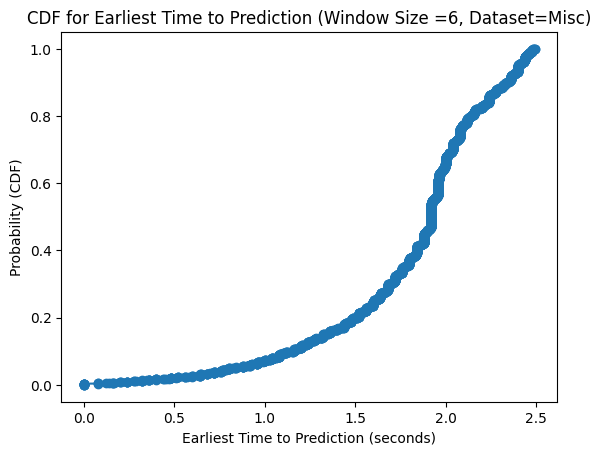

                 0
count  2705.000000
mean      1.802386
std       0.466354
min       0.000000
25%       1.602827
50%       1.919994
75%       2.080002
max       2.493137
90:  99.48243992606285
100:  99.48243992606285
200:  99.22365988909428
500:  97.81885397412199
1000:  92.71719038817005


In [ ]:
%matplotlib inline
# Declare num of datapoints
N = len(earliest_times)

x = np.sort(earliest_times)
y = np.arange(N) / float(N)

plt.xlabel("Earliest Time to Prediction (seconds)")
plt.ylabel("Probability (CDF)")
plt.title("CDF for Earliest Time to Prediction (Window Size =" + str(WINDOW_SIZE) +", Dataset=Misc)")

plt.plot(x,y, marker='o')
plt.show()

earliest_times_df = pd.DataFrame(earliest_times)
print(earliest_times_df.describe())


g100 = 0
g200 = 0
g500 = 0
g1000 = 0
g90 = 0

for x in earliest_times:
  if x >= 0.09:
    g90 += 1
  if x >= 0.1:
    g100 += 1
  if x >= 0.2:
    g200 += 1
  if x >= 0.5:
    g500 += 1
  if x >= 1:
    g1000 += 1

print("90: ", g90/N * 100)
print("100: ", g100/N * 100)
print("200: ", g200/N * 100)
print("500: ", g500/N * 100)
print("1000: ", g1000/N * 100)

with open("ICNP_HO_predictions.txt", "w") as output:
    for item in earliest_times:
        output.write(str(item) + "\n")


# BASE STATION PREDICTION

## Evaluating for Top N Base Stations predicted

## Setting up helper functions

In [10]:
# streamlining pipeline by encompassing in functions

# helper function that predicts handoever events, and returns a dictionary which maps each handover event to the time at which the handover event is predicted
def predict_HO_events(input_features, input_labels, model_eval, sequence_dict, sequence_dict_orig, sequence_dict_checker):
  # TODO: add exact variable type information for all the parameters
  # input_features : list of all input features for which predictions have to be made
  # input_labels : list of labels
  # model_eval : keras model being used for evaluation
  # sequence_dict : dictionary keeping track of a measurement and result pairing. i.e., which index in the resulting matrix refers to a specific measurement

  predictions = model_eval.predict(input_features)
  bool_predictions = (predictions > 0.37)
  cm = confusion_matrix(input_labels, bool_predictions)
  tn, fp, fn, tp = cm.ravel()

  earliest_HO_times = {}
  TOTAL_VALID_EVENTS = 0
  FAILED_PREDICTING = 0

  # Predicting handover events
  for HO_COUNT, key in enumerate(sequence_dict.keys()):
    # variable that checks if the handover for the current event has been predicted
    HO_PREDICTED = False
    ho_event_list = sequence_dict[key]
    if check_valid_2(sequence_dict_checker, key):
      TOTAL_VALID_EVENTS += 1
      for i1, entry in enumerate(ho_event_list): # check for the current HO event
        if entry is not None:
          for i2, subentry in enumerate(entry): # this inner loop checks everything for a single base station
            req_idx = sequence_dict[key][i1][i2][0]
            label = input_labels[req_idx][0]
            curr_ts = sequence_dict[key][i1][i2][3]
            prediction = bool_predictions[req_idx]
            if prediction == 1: # if a handover is predicted
              HO_PREDICTED = True
              if key in earliest_HO_times:
                if curr_ts > earliest_HO_times[key]:
                  earliest_HO_times[key] = curr_ts
              else:
                earliest_HO_times[key] = curr_ts
      if HO_PREDICTED == False:
        FAILED_PREDICTING += 1

  return earliest_HO_times, TOTAL_VALID_EVENTS, FAILED_PREDICTING, predictions, bool_predictions

# helper function that gets confidence values/probabilities
def get_probabilities(sequence_dict, sequence_dict_orig, sequence_dict_checker, actual_labels, predictions_probs, predictions_bools, earliest_HO_times):
  HO_to_ts_dict = {}
  HO_label_dict = {}

  # First iteration should be about going through each base station and getting confidence values for each BS
  for HO_COUNT, key in enumerate(sequence_dict.keys()): # Each iteration refers to each Handover event
    ho_event_list = sequence_dict[key]
    HO_to_ts_dict[key] = {}
    if check_valid_2(sequence_dict_checker, key): # Check if this HO event is usable (is the data entry clean enough to be usable?)
      for i1, entry in enumerate(ho_event_list): # i1 can be used to identify the base station
        if entry is not None:
          HO_to_ts_dict[key][i1] = {}
          for i2, subentry in enumerate(entry):
            req_idx = sequence_dict[key][i1][i2][0]
            label = actual_labels[req_idx][0]
            curr_ts = sequence_dict[key][i1][i2][3]
            prediction = predictions_bools[req_idx]
            prediction_probability = predictions_probs[req_idx][0]
            if label == 1:
              HO_label_dict[key] = i1
            try:
              if curr_ts <= earliest_HO_times[key]:
                # handover prediction has happened, base station prediction can be performed
                HO_to_ts_dict[key][i1][curr_ts] = prediction_probability
            except:
              # Evaluated the number of events for which HO was not predicted - add them to our evaluation
              pass

  # HO_to_ts_dict has the following structure:
  # {handover_id : {base_station_id : {timestamp : probability}}}
  # Number of base stations on which state will be replicated. For every handover event, we will consider the top candidates from these two base stations
  earliest_time_BSP = [] # Number of BSP failures can be calculated as a difference in number of handover events predictions, and number of BSP earliest time predictions

  # need to keep track of another pairing:
  # {handover_id : {timestamp : {probability : base_station_id}}} => ts_prob_pairing
  ts_prob_pairing = {}
  # also need to keep a track of a list of sorted probabilities at each timestamp
  # {handover_id: {timestamp : [sorted probabilities] }}
  ts_probabilities = {}

  for handover_key in HO_to_ts_dict.keys():
    all_bs_info = HO_to_ts_dict[handover_key] # for a handover event with id = handover_key, this dict contains information of all BSes
    ts_prob_pairing[handover_key] = {}
    ts_probabilities[handover_key] = {}
    for bs_id in all_bs_info.keys():
      bs_info = all_bs_info[bs_id] # should contain information for a single base station for a single handover event
      for ts in bs_info.keys():
        curr_bs_ts_prob = bs_info[ts]
        # Add pairing to keep track of which probability we are considering
        if ts not in ts_prob_pairing[handover_key].keys():
          ts_prob_pairing[handover_key][ts] = {}
          ts_prob_pairing[handover_key][ts][curr_bs_ts_prob] = bs_id
        else:
          ts_prob_pairing[handover_key][ts][curr_bs_ts_prob] = bs_id
        # Append to list of probabilities
        if ts not in ts_probabilities[handover_key].keys():
          ts_probabilities[handover_key][ts] = [curr_bs_ts_prob]
        else:
          ts_probabilities[handover_key][ts].append(curr_bs_ts_prob)
          ts_probabilities[handover_key][ts] = sorted(ts_probabilities[handover_key][ts], reverse=True)

  return ts_probabilities, ts_prob_pairing, HO_label_dict

# helper function that returns a list with time to prediction
def get_time_to_predictions(ts_probabilities, ts_prob_pairing, HO_label_dict, top_N):
  # ts_probabilities => {handover_id: {timestamp : [sorted probabilities] }}
  # ts_prob_pairing => {handover_id : {timestamp : {probability : base_station_id}}} => ts_prob_pairing
  # HO_label_dict is a dictionary that contains the label index for each handover event
  # top_N is a number which indicates how many BSes we intend to have as targets

  HO_BSP_FAILURES = 0
  earliest_time_BSP = []

  for handover_key in ts_probabilities.keys():
    timestamps = ts_probabilities[handover_key]
    timestamps = sorted(timestamps, reverse=True)
    if timestamps == []:
      continue
    BSP_PREDICTED = False
    actual_label = HO_label_dict[handover_key]
    for ts in timestamps:
      probs = sorted(ts_probabilities[handover_key][ts], reverse=True)
      if BSP_PREDICTED == True:
        break
      num_probs_to_check = min(top_N, len(ts_probabilities[handover_key][ts])) # the number of probabilities to read: this is the min of number of available BSes,
      for i in range(num_probs_to_check):
        if BSP_PREDICTED == True:
          break
        predicted_label = ts_prob_pairing[handover_key][ts][probs[i]]
        if predicted_label == actual_label:
          BSP_PREDICTED = True
          earliest_time_BSP.append(ts)

  return earliest_time_BSP

# helper function to print out the graph
def print_results(earliest_times, output_fname, handover_count):
  # %matplotlib inline

  # Declare num of datapoints
  # N = len(earliest_times)
  N = handover_count

  x = np.sort(earliest_times)
  y = np.arange(N) / float(N)

  # print(earliest_times)

  # plt.xlabel("Earliest Time to Prediction (seconds)")
  # plt.ylabel("Probability (CDF)")
  # plt.title("CDF for Earliest Time to Prediction (Window Size = 6, Dataset=HSR)")

  # plt.plot(x,y, marker='o')
  # plt.show()
  # print(earliest_times)

  earliest_times_df = pd.DataFrame(earliest_times)
  print(earliest_times_df.describe())

  g100 = 0
  g200 = 0
  g500 = 0
  g1000 = 0
  g90 = 0

  for x in earliest_times:
    if x >= 0.09:
      g90 += 1
    if x >= 0.1:
      g100 += 1
    if x >= 0.2:
      g200 += 1
    if x >= 0.5:
      g500 += 1
    if x >= 1:
      g1000 += 1

  print("100: ", g100/N * 100)
  print("200: ", g200/N * 100)
  print("500: ", g500/N * 100)
  print("1000: ", g1000/N * 100)

  with open(output_fname, "w") as output:
      for item in earliest_times:
          output.write(str(item) + "\n")


# helper function to print out the graph
def print_results_incp(earliest_times, output_fname, handover_count):
  # %matplotlib inline

  # Declare num of datapoints
  N = len(earliest_times)
  # N = handover_count

  # x = np.sort(earliest_times)
  # y = np.arange(N) / float(N)

  # plt.xlabel("Earliest Time to Prediction (seconds)")
  # plt.ylabel("Probability (CDF)")
  # plt.title("CDF for Earliest Time to Prediction (Window Size = 6, Dataset=INCP)")

  # plt.plot(x,y, marker='o')
  # plt.show()

  earliest_times_df = pd.DataFrame(earliest_times)
  print(earliest_times_df.describe())

  g100 = 0
  g200 = 0
  g500 = 0
  g1000 = 0
  g90 = 0

  for x in earliest_times:
    if x >= 0.08:
      g90 += 1
    if x >= 0.1:
      g100 += 1
    if x >= 0.2:
      g200 += 1
    if x >= 0.5:
      g500 += 1
    if x >= 1:
      g1000 += 1
  print("100: ", g100/N * 100)
  print("200: ", g200/N * 100)
  print("500: ", g500/N * 100)
  print("1000: ", g1000/N * 100)

  with open(output_fname, "w") as output:
      for item in earliest_times:
          output.write(str(item) + "\n")

In [11]:
# putting all the above helper functions together
def get_top_n_results(model_eval, input_features, input_labels, sequence_dict, sequence_dict_orig, sequence_dict_checker, top_N, output_fname):
  # predicting handover events and getting relevant timestamps
  earliest_HO_times, TOTAL_VALID_EVENTS, FAILED_PREDICTING, predictions_probs, predictions_bools = predict_HO_events(input_features, input_labels, model_eval, sequence_dict, sequence_dict_orig, sequence_dict_checker)
  # getting relevant probability relations and pairings with handover events
  ts_probabilities, ts_prob_pairing, HO_label_dict = get_probabilities(sequence_dict, sequence_dict_orig, sequence_dict_checker, input_labels, predictions_probs, predictions_bools, earliest_HO_times)
  # getting a list of earliest time to predictions
  earliest_times_BSP = get_time_to_predictions(ts_probabilities, ts_prob_pairing, HO_label_dict, top_N)
  # generating graphs and getting the relevant results
  print_results(earliest_times_BSP, output_fname, TOTAL_VALID_EVENTS)

# putting all the above helper functions together
def get_top_n_results_incp(model_eval, input_features, input_labels, sequence_dict, sequence_dict_orig, sequence_dict_checker, top_N, output_fname):
  # predicting handover events and getting relevant timestamps
  earliest_HO_times, TOTAL_VALID_EVENTS, FAILED_PREDICTING, predictions_probs, predictions_bools = predict_HO_events(input_features, input_labels, model_eval, sequence_dict, sequence_dict_orig, sequence_dict_checker)
  # getting relevant probability relations and pairings with handover events
  ts_probabilities, ts_prob_pairing, HO_label_dict = get_probabilities(sequence_dict, sequence_dict_orig, sequence_dict_checker, input_labels, predictions_probs, predictions_bools, earliest_HO_times)
  # getting a list of earliest time to predictions
  earliest_times_BSP = get_time_to_predictions(ts_probabilities, ts_prob_pairing, HO_label_dict, top_N)
  # generating graphs and getting the relevant results
  print_results_incp(earliest_times_BSP, output_fname, TOTAL_VALID_EVENTS)


## Evaluating a theoretical maximum

In [24]:
def max_achievable(sequence_dict, sequence_dict_checker, actual_labels):
    best_possible = []

    # extracting the best possible times from the loaded data
    for HO_COUNT, key in enumerate(sequence_dict.keys()): # Each iteration refers to each Handover event
        ho_event_list = sequence_dict[key]
        if check_valid_2(sequence_dict_checker, key): # Check if this HO event is usable (is the data entry clean enough to be usable?)
            time_noted = False
            for i1, entry in enumerate(ho_event_list): # i1 can be used to identify the base station
                    if entry is not None:
                        if not time_noted:
                            for i2, subentry in enumerate(entry):
                                req_idx = sequence_dict[key][i1][i2][0]
                                label = actual_labels[req_idx][0]
                                curr_ts = sequence_dict[key][i1][i2][3]
                                if label:
                                    best_possible.append(curr_ts)
                                    time_noted = True
                                    break
                        else:
                            break
    
    # Evaluating the best possible times
    df = pd.DataFrame(best_possible)
    print(df.describe())

    N = len(best_possible)
    g100 = 0
    g200 = 0
    g500 = 0
    g1000 = 0

    for x in best_possible:
        if x >= 0.1:
            g100 += 1
        if x >= 0.2:
            g200 += 1
        if x >= 0.5:
            g500 += 1
        if x >= 1:
            g1000 += 1

    print("100: ", g100/N * 100)
    print("200: ", g200/N * 100)
    print("500: ", g500/N * 100)
    print("1000: ", g1000/N * 100)

                            
max_achievable(HSR_seq_dict, HSR_seq_dict_checker, HSR_labels)


                0
count  405.000000
mean     1.009009
std      0.543597
min      0.000000
25%      0.562871
50%      1.073573
75%      1.401144
max      2.287975
100:  92.8395061728395
200:  90.12345679012346
500:  77.53086419753087
1000:  54.32098765432099


## Evaluation of HSR Dataset

In [17]:
_, _, HSR_seq_dict_checker, HSR_seq_dict_checker_orig = load_dataset(HSR_datasets, 6)
HSR_features, HSR_labels, HSR_seq_dict, HSR_seq_dict_orig = load_dataset_padding(HSR_datasets, 6)

DIFF COUNT CHECK: 0


In [66]:
for i in range(1,6):
  output_fname = "HSR_LE" + str(i) + "_earliest.txt"
  get_top_n_results(model_eval, HSR_features, HSR_labels, HSR_seq_dict, HSR_seq_dict_orig, HSR_seq_dict_checker, i, output_fname)

507/507 [==============================] - 4s 7ms/step
                0
count  365.000000
mean     0.928362
std      0.522486
min      0.000000
25%      0.485091
50%      0.957862
75%      1.322110
max      2.287975
100:  83.4567901234568
200:  80.49382716049382
500:  66.91358024691358
1000:  43.45679012345679
507/507 [==============================] - 3s 7ms/step
                0
count  394.000000
mean     0.942045
std      0.535105
min      0.000000
25%      0.501832
50%      0.956960
75%      1.355617
max      2.287975
100:  89.62962962962962
200:  86.66666666666667
500:  72.8395061728395
1000:  47.40740740740741
507/507 [==============================] - 3s 7ms/step
                0
count  397.000000
mean     0.960297
std      0.532270
min      0.000000
25%      0.554131
50%      1.000741
75%      1.362189
max      2.287975
100:  90.37037037037037
200:  87.65432098765432
500:  75.30864197530865
1000:  49.135802469135804
507/507 [==============================] - 3s 7ms/step
    

## Evaluation of Misc Dataset

In [27]:
_, _, misc_seq_dict_checker, misc_seq_dict_checker_orig = load_dataset(Misc_datasets, 6)
misc_features, misc_labels, misc_seq_dict, misc_seq_dict_orig = load_dataset_padding(Misc_datasets, 6)

DIFF COUNT CHECK: 0


In [29]:
max_achievable(misc_seq_dict, misc_seq_dict_checker, misc_labels)

                0
count  104.000000
mean     1.531641
std      0.769742
min      0.000000
25%      0.891234
50%      1.889463
75%      2.197960
max      2.224869
100:  96.15384615384616
200:  89.42307692307693
500:  81.73076923076923
1000:  71.15384615384616


In [68]:
for i in range(1,6):
  output_fname = "misc_LE" + str(i) + "_earliest.txt"
  get_top_n_results(model_eval, misc_features, misc_labels, misc_seq_dict, misc_seq_dict_orig, misc_seq_dict_checker, i, output_fname)

422/422 [==============================] - 4s 8ms/step
                0
count  101.000000
mean     1.441292
std      0.761984
min      0.000000
25%      0.807150
50%      1.755004
75%      2.185353
max      2.224869
100:  93.26923076923077
200:  86.53846153846155
500:  78.84615384615384
1000:  64.42307692307693
422/422 [==============================] - 3s 7ms/step
                0
count  104.000000
mean     1.485201
std      0.777190
min      0.000000
25%      0.807150
50%      1.801061
75%      2.197811
max      2.224869
100:  96.15384615384616
200:  89.42307692307693
500:  80.76923076923077
1000:  70.1923076923077
422/422 [==============================] - 3s 8ms/step
                0
count  104.000000
mean     1.531641
std      0.769742
min      0.000000
25%      0.891234
50%      1.889463
75%      2.197960
max      2.224869
100:  96.15384615384616
200:  89.42307692307693
500:  81.73076923076923
1000:  71.15384615384616
422/422 [==============================] - 3s 7ms/step
    

## Evaluation of ICNP Dataset

In [12]:
incp_datasets = ["icnp-dataset/ATT", "icnp-dataset/TMobile"]
_, _, incp_seq_checker_dict, incp_seq_checker_dict_orig = load_incp_dataset(WINDOW_SIZE=6)
incp_features, incp_labels, incp_seq_dict, incp_seq_dict_orig = load_incp_dataset_padding(6)

In [26]:
max_achievable(incp_seq_dict, incp_seq_checker_dict, incp_labels)

                 0
count  2709.000000
mean      1.597130
std       0.513066
min      -0.169931
25%       1.341872
50%       1.782863
75%       1.960002
max       2.481226
100:  99.07715023994093
200:  97.96973052787006
500:  94.49981543004799
1000:  85.97268364710226


In [14]:
for i in range(1,6):
  output_fname = "incp_LE" + str(i) + "_earliest.txt"
  get_top_n_results_incp(model_eval, incp_features, incp_labels, incp_seq_dict, incp_seq_dict_orig, incp_seq_checker_dict, i, output_fname)

2023-06-20 02:37:59.506945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-20 02:37:59.512909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-20 02:37:59.516234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8395/8395 [==============================] - 57s 7ms/step
                 0
count  2586.000000
mean      1.634501
std       0.588476
min      -0.169931
25%       1.320014
50%       1.815016
75%       2.033736
max       2.493137
100:  98.10518174787316
200:  96.98375870069606
500:  93.07811291569992
1000:  84.37741686001546
8395/8395 [==============================] - 52s 6ms/step
                 0
count  2685.000000
mean      1.728172
std       0.513306
min       0.000000
25%       1.511836
50%       1.880018
75%       2.040061
max       2.493137
100:  99.14338919925511
200:  98.58472998137803
500:  96.1266294227188
1000:  89.75791433891993
8395/8395 [==============================] - 53s 6ms/step
                 0
count  2703.000000
mean      1.749207
std       0.494526
min       0.000000
25%       1.521067
50%       1.884977
75%       2.041139
max       2.493137
100:  99.4820569737329
200:  98.96411394746578
500:  96.78135405105438
1000:  90.97299297077322
8395/8395 [=============